# Comparing Image Retrival with and without Generalizer

### Imports

In [72]:
import os
import json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from textwrap import wrap

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/michael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/michael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
image_path = "Images"
model_path = "image_caption_model_data"

### Load Image Captioning Model

#### Load Models and Tokenizer

In [74]:
caption_model = tf.keras.models.load_model(model_path+'/caption_model.keras')
with open(model_path+'/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)
dense_net_201_model = DenseNet201()
feature_extraction_model = Model(inputs=dense_net_201_model.input, outputs=dense_net_201_model.layers[-2].output)

In [75]:
def extract_features(images: list):
    img_size = 224
    features = {}
    for image in tqdm(images):
        img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
        img = img_to_array(img)
        img = img/255.
        img = np.expand_dims(img,axis=0)
        feature = feature_extraction_model.predict(img, verbose=0)
        features[image] = feature
    return features

In [76]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [77]:
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

#### Generate Captions

In [78]:
images = os.listdir(image_path)
features = extract_features(images)

100%|██████████| 83/83 [00:05<00:00, 14.01it/s]


In [79]:
image_data = []

for image in images:
    img = load_img(os.path.join(image_path, image),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, image, tokenizer, 34, features)
    generalized_caption = caption #Todo: Add Generalizer here!
    image_data.append((image, caption, generalized_caption))

image_data_df = pd.DataFrame(image_data, columns=['image','caption','generalized_caption'])

1/1 [==============================] - 0s 14ms/step


### Indexing Images

In [80]:
class Preprocessor:
    def __init__(self):
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.stemmer = PorterStemmer()

    def preprocess_string(self, data: str) -> list:
        # remove stopwords
        removed_stoppwords = []
        caption = data.lower()
        for word in caption.split():
            if word not in self.stopwords:
                removed_stoppwords.append(word)
        removed_stoppwords = " ".join(removed_stoppwords)

        # remove numbers and punctuation
        text_only = ""
        for character in removed_stoppwords:
            if character.isalpha() or character == " ":
                text_only += character
            else:
                text_only += " "

        # Tokenization
        tokenized = nltk.word_tokenize(text_only)

        # Stemming
        stemmed = [self.stemmer.stem(token) for token in tokenized]
        return stemmed

    def preprocess_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        df["tokens"] = df["caption"].astype(object)
        df["tokens_generalized"] = df["generalized_caption"].astype(object)
        for index, row in df.iterrows():
            df["tokens"][index] = self.preprocess_string(str(row["caption"]))
            df["tokens_generalized"][index] = self.preprocess_string(str(row["generalized_caption"]))
        return df
    
    def create_lookup_table(self, df: pd.DataFrame) -> dict[str,int]:
        all_tokens = df['tokens'].apply(pd.Series).stack().unique().tolist()
        all_tokens += df['tokens_generalized'].apply(pd.Series).stack().unique().tolist()
        all_tokens = set(all_tokens)
        lookup_table = {}
        i = 0
        for word in all_tokens:
            lookup_table[word] = i
            i+=1
        return lookup_table
    
    def create_reduced_document_index(self, df: pd.DataFrame, column: str, lookup_table: dict) -> list:
        document_counts = []
        for _, row in df.iterrows():
            binary_token_count = np.zeros(len(lookup_table))
            for token in row[column]:
                binary_token_count[lookup_table[token]] = 1
            document_counts.append((row["image"], binary_token_count))
        return document_counts

In [81]:
preprocessor = Preprocessor()
processed_df = preprocessor.preprocess_dataset(image_data_df)
lookup_table = preprocessor.create_lookup_table(processed_df)
searchable_images = preprocessor.create_reduced_document_index(processed_df,'tokens',lookup_table)
searchable_images_generalized = preprocessor.create_reduced_document_index(processed_df,'tokens_generalized',lookup_table)

### Searching

In [82]:
def search(lookup_table: dict, query_tokenized : list, documents: list) -> list:
    results = []
    compareable = np.zeros(len(lookup_table))
    for token in query_tokenized:
        if token in lookup_table:
            compareable[lookup_table[token]] = 1
    query_sum = np.sum(compareable.astype(int))

    if query_sum == 0:
        return []

    for document in documents:
        comparision = compareable.astype(bool) & document[1].astype(bool)
        comparison_sum = np.sum(comparision)
        if query_sum == comparison_sum:
            results.append(document[0])
    return results

In [83]:
def display_images(images):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(min(25,len(images))):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(f"Images/{images[i]}",color_mode='rgb',target_size=(224,224))
        image = img_to_array(image)
        image = image/255.
        plt.imshow(image)
        plt.axis("off")

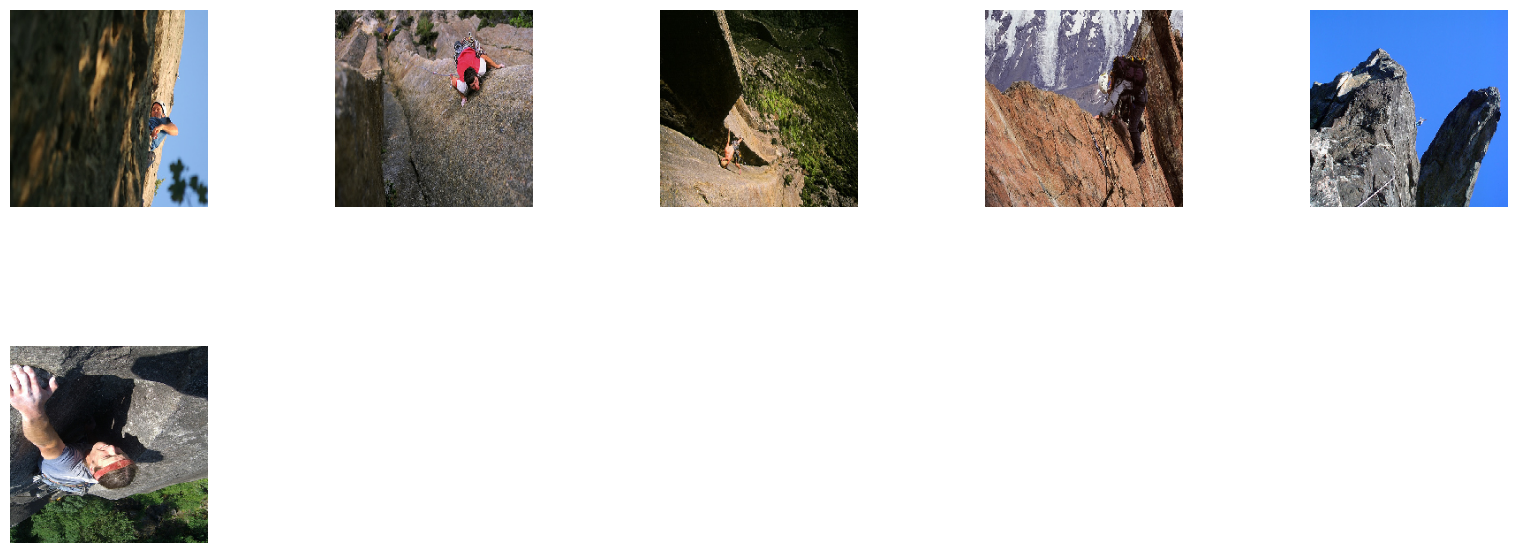

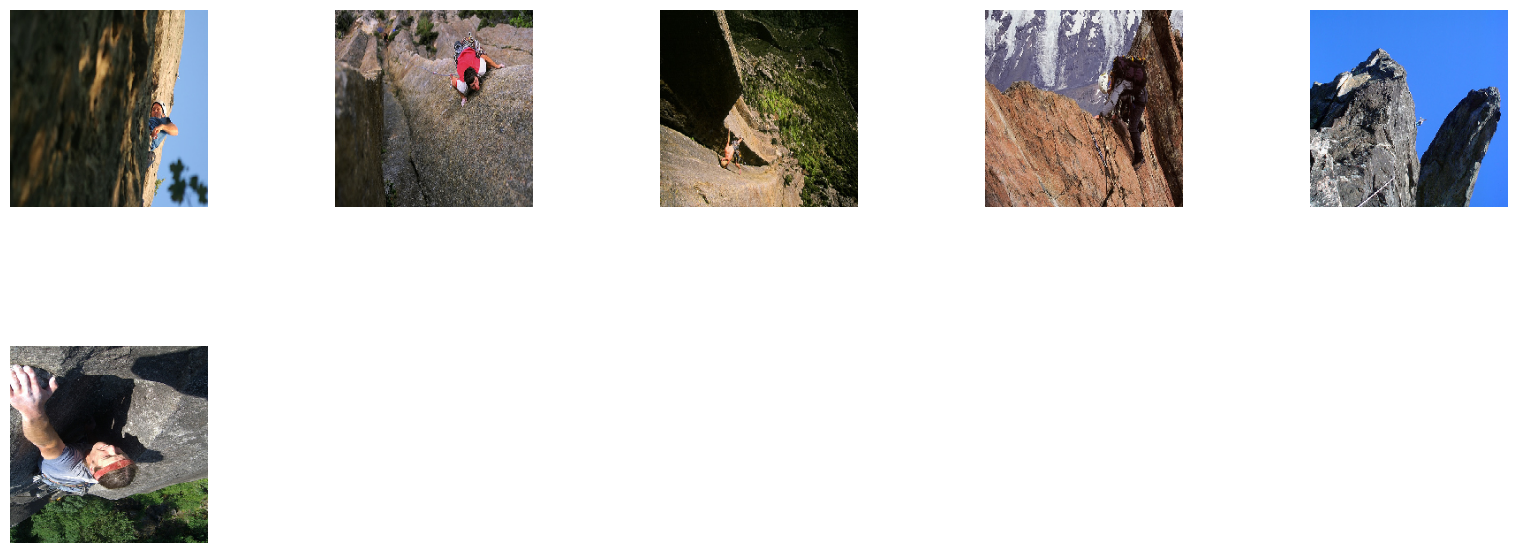

In [86]:
query = "climbing"
query_tokenized = preprocessor.preprocess_string(query)

results = search(lookup_table, query_tokenized, searchable_images)
results_generalized = search(lookup_table, query_tokenized, searchable_images_generalized)

display_images(results)
display_images(results_generalized)